
<font size="5">**<center> ĐỒ ÁN 01 </center>** </font>

<font size="4">**<center> Thu nhập dữ liệu & EDA </center>** </font>

> Họ tên: Thái Bá Sơn

> MSSV: 1712732

# I/ Dữ liệu

### Thông tin về dữ liệu:

Dữ liệu được khai thác từ trang chủ Soundcloud. Thu thập các thông tin về track, user và playlist bằng phương pháp parse HTML.  

**Nguồn:** dữ liệu được khai thác [tại đây](https://www.soundcloud.com)

# II/ Khám phá dữ liệu:

## 1/ Thu thập dữ liệu:

### Import

In [133]:
import requests
import json
import time # Dùng để sleep chương trình
import pandas as pd # Dùng để đọc và hiển thị file csv 
import datetime as dt # Dùng để xử lý dữ liệu thời gian
import re
import soundcloud
import logging
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
#Import thư viện:
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException

### a/ API:

Vì Soundcloud đã ngưng cấp phép cho việc khai thác API nên không khai thác được.

### b/ parse HTML:

- Sử dụng thư viện selenium tương tác với trang chủ Soundcloud để lấy thông tin về link các playlist:

In [2]:
# Mở Chrome và cho full màn hình
browser = webdriver.Chrome(ChromeDriverManager().install())
browser.maximize_window()

[WDM] - Current google-chrome version is 86.0.4240
[WDM] - Get LATEST driver version for 86.0.4240


[WDM] - Get LATEST driver version for 86.0.4240
[WDM] - Trying to download new driver from http://chromedriver.storage.googleapis.com/86.0.4240.22/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\dell\.wdm\drivers\chromedriver\win32\86.0.4240.22]


- (Hàm truy cập và đợi cho trang load xong)

In [3]:
#Tải trang cho đến hết:
def load_link(browser, link):
    #Vào link:
    browser.get(link)
    
    #Xóa quảng cáo:
    dismiss = browser.find_elements_by_class_name('announcement__dismiss')
    dismiss[0].click()
    
    #Cuộn trang
    SCROLL_PAUSE_TIME = 3

    # Get scroll height
    last_height = browser.execute_script("return document.body.scrollHeight")

    while True:
        # Scroll down to bottom
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = browser.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

- Từ trang chủ soundcloud/discover, dùng các gợi ý playlist để lấy các link playlist phục vụ cho việc khai thác. 

In [23]:
link_browser = 'https://soundcloud.com/discover'

#Mở trang chủ của Soundcloud và load trang: 
load_link(browser, link_browser)

#Chờ trang tải:
time.sleep(4)

#load toàn bộ trang để hiện nhiều playlist nhất 
buttons = browser.find_elements_by_class_name('tileGallery__sliderPeekForward')
t = 0
l = len(buttons)
while t < l: 
    if buttons[t].is_displayed():
        buttons[t].click()
    else:
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        t+=1

In [24]:
# Xuất link tất cả playlist
playlists = browser.find_elements_by_class_name('audibleTile__audibleHeading')
print("Số link playlist thu được: ", len(playlists))

#Xuất kết quả vào file link_playlists.txt
f = open('link_playlists.txt', 'w')
for playlist in playlists:
    if playlist.get_attribute('href'):
        f.write("{}\n".format(playlist.get_attribute('href')))
f.close()


Số link playlist thu được:  300


### Lọc thông tin về track, playlist từ danh sách link playlist:

- Thu thập dữ liệu từ playlist gợi ý ở trang chủ Soundcloud:

In [5]:
#Lưu thông tin playlist vào file:
def file_write(filename, track_list, track_link_list, user_name_list, user_link_list, playcount_list, duration_list):
    with open(filename, 'a', encoding='utf-8') as f:
        for i in range(len(track_list)):
            f.write(f'{track_list[i]}\t{track_link_list[i]}\t{user_name_list[i]}\t{user_link_list[i]}\t{playcount_list[i]}\t{duration_list[i]}\n')
        f.close()

In [6]:
#Hàm tương tác với trang để lấy thông tin và lưu vào file:
def get_playlist_info(playlist_file, track_file, browser, link):
    #Tải hết trang:
    load_link(browser, link)
    
    time.sleep(3)
    browser.find_element_by_tag_name('html').send_keys(Keys.ESCAPE)
    
    PAUSE_TIME = 0.2
    
    #List:
    track_list = []
    track_link_list = []
    user_name_list = []
    user_link_list = []
    playcount_list = []
    duration_list = []
    empty = []
    
    time.sleep(2)
    #Tìm tên track
    tracks = browser.find_elements_by_class_name('trackItem__trackTitle')
    number_track = len(tracks)
    for i in range(len(tracks)):
        track_name = tracks[i].text
        track_list.append(track_name)
        track_link_list.append(tracks[i].get_attribute('href'))
    
    
    users = browser.find_elements_by_class_name('trackItem__username')
    for i in range(len(users)):
        if users[i].get_attribute('href'):
            user_link = users[i].get_attribute('href')
            user_name_list.append(users[i].text)
        else: 
            user_name_list.append(users[i].text)
            user_link = 'None'
        user_link_list.append(user_link)
        
    time.sleep(6)
    #Thêm vào playcount
    playcounts = browser.find_elements_by_class_name('trackItem__additional')
    for i in range(len(users)):
        if playcounts[i].text == 'Not available in Viet Nam':
            empty.append(i)
            playcount = None
        else:
            if len(playcounts[i].text) > 10:
                playcount = None
            else:
                playcount = playcounts[i].text
        playcount_list.append(playcount)
    
    track_durations = browser.find_elements_by_class_name('playbackTimeline__duration')
    for i in range(len(users)):
        if i in empty:
            duration_list.append(None)
        if track_durations[0].text:
            track_duration = str(track_durations[0].text.split('\n')[1])
        else:
            track_duration = None
        duration_list.append(track_duration)
        browser.find_elements_by_class_name('skipControl__next')[0].click()
        time.sleep(PAUSE_TIME)    
        
    file_write(track_file, track_list, track_link_list, user_name_list, user_link_list, playcount_list, duration_list)
    
    time.sleep(3)
    try:
        playlist_name = browser.find_element_by_class_name('soundTitle__title').text
    except NoSuchElementException:
        playlist_name = browser.find_element_by_class_name('fullHero__titleTextLineBig').text
    try:
        playlist_owner_name = browser.find_element_by_class_name('userBadge__usernameLink').text
        playlist_owner_url = browser.find_element_by_class_name('userBadge__usernameLink').get_attribute('href')
        playlist_likes = browser.find_element_by_class_name('sc-ministats-likes').text.split('\n')[1]
        playlist_posted_time = \
            browser.find_element_by_class_name('relativeTime').get_attribute('datetime').split('T')[0]

    except NoSuchElementException:
        playlist_owner_name = ''
        playlist_owner_url = ''
        playlist_likes = ''
        playlist_posted_time = ''
    f_playlist = open(playlist_file, 'a', encoding='utf-8')
    f_playlist.write(f'{playlist_name}\t{playlist_owner_name}\t{playlist_owner_url}\t{number_track}\t{playlist_posted_time}\t{playlist_likes}\n')
    f_playlist.close()

- Load tất cả các link playlist thu được và trả về lượng thông tin nạp vào file track.csv và playlist.csv

In [31]:
f = open('track.csv', 'w', encoding='utf-8')
f.write('Track_name\tTrack_link\tUser_name\tUser_link\tPlay_count\tDuration\n')
f.close()

f = open('playlist.csv', 'w', encoding='utf-8')
f.write('playlist_name\tplaylist_owner_name\tplaylist_owner_url\tnumber_track\tplaylist_posted_time\tplaylist_likes\n')
f.close()

f = open('user.csv', 'w', encoding='utf-8')
f.write('User_name\tUser_link\tUser_type\tFollower\tFollowing\tTrack_count\n')
f.close()

In [33]:
#Run
file = open('link_playlists.txt', 'r')
start = time.time()
for link in file:
        get_playlist_info('playlist.csv', 'track.csv', browser, link)
file.close()
print(time.time() - start)

8836.687911987305


### Lọc thông tin user từ danh sách link user (chứa trong track.csv):

- Lấy ngẫu nhiên 2000 user link từ file track.csv để khai thác thông tin user 

In [21]:
f = open('track.csv', 'r', encoding='utf-8')
jobs = f.readlines()
test = random.choices(jobs[1:], k=2000)
f.close()

In [22]:
with open('link_user.csv', 'w', encoding='utf-8') as f:
    for i in test:
        user_link = i.split('\t')[3]
        f.write(f'{user_link}\n')
f.close()

- Hàm lấy thông tin từ user_link và lưu vào file .csv:

In [74]:
def get_user_info(filename, browser, link):
    user_link = link.replace('\n', '')
    SLEEP_TIME = 1
    
    #truy cập link:
    browser.get(link)
    time.sleep(SLEEP_TIME)
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    #Lấy thông tin:
    try:
        user_name = browser.find_elements_by_class_name('profileHeaderInfo__userName')[0].text.split('Pro')[0]
        follower = browser.find_elements_by_class_name('infoStats__value')[0].text
        following = browser.find_elements_by_class_name('infoStats__value')[1].text
        track_count = browser.find_elements_by_class_name('infoStats__value')[2].text
    except NoSuchElementException:
        user_name = None
        follower = None
        following = None
        track_count = None
    try:
        star = browser.find_element_by_class_name('profileHeaderInfo__premiumIndicator').text
        user_type = star
    except NoSuchElementException:
        user_type = 'Basic'
    f_playlist = open(filename, 'a', encoding='utf-8')
    f_playlist.write(f'{user_name}\t{user_link}\t{user_type}\t{follower}\t{following}\t{track_count}\n')
    

In [80]:
#Thiếu dữ liệu 1191 (bd từ 1) do user k tồn tại
f = open('link_user.csv', 'r', encoding='utf-8')
start = time.time()
for line in f:
        get_user_info('user1.csv', browser, line)
f.close()
print(time.time() - start)

1141.0282909870148


## 2/ Tiền xử lý:

> **File track.csv:**

In [13]:
df_track = pd.read_csv("track.csv", sep = '\t')
df_track.head()

,Track_name,Track_link,User_name,User_link,Play_count,Duration
0,Zara Larsson - Uncover (Millesim Remix),https://soundcloud.com/millesimofficial/zara-l...,Millesim,https://soundcloud.com/millesimofficial,None,3:54
1,The Chainsmokers Ft. GGFO - Let You Go (Aash M...,https://soundcloud.com/aash-mehta/let-you-go?i...,Aash Mehta,https://soundcloud.com/aash-mehta,8.78M,5:12
2,Birds Fly (Commentary Bonus Version) [feat. Mr...,https://soundcloud.com/hardwell/hardwell-feat-...,HARDWELL,https://soundcloud.com/hardwell,6.6M,None
3,KDrew - Tonight (GRMM Remix),https://soundcloud.com/hegemon/kdrew-tonight-g...,Hegemon Select,https://soundcloud.com/hegemon,6.94M,4:03
4,The Light (Acoustic Version),https://soundcloud.com/armadamusic/disco-fries...,Armada Music,https://soundcloud.com/armadamusic,5.5M,3:20


- Thông tin dữ liệu:

In [14]:
rows, collumns = df_track.shape
print("Dữ liệu có {} dòng và {} cột".format(rows, collumns))

Dữ liệu có 10725 dòng và 6 cột


In [15]:
df_track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10725 entries, 0 to 10724
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Track_name  10725 non-null  object
 1   Track_link  10725 non-null  object
 2   User_name   10725 non-null  object
 3   User_link   10725 non-null  object
 4   Play_count  10672 non-null  object
 5   Duration    10725 non-null  object
dtypes: object(6)
memory usage: 502.9+ KB


(Dữ liêu "Play count" bị thiếu vì trong lúc khai thác dữ liệu quy định nếu không xuất hiện thông tin thì trả về None)

- Xóa đi những dòng bị thiếu dữ liệu:


In [118]:
df1 = df_track.copy()
df1.dropna(axis=0, inplace=True)
df1 = df1.mask(df1.eq('None')).dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9863 entries, 1 to 10724
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Track_name  9863 non-null   object
 1   Track_link  9863 non-null   object
 2   User_name   9863 non-null   object
 3   User_link   9863 non-null   object
 4   Play_count  9863 non-null   object
 5   Duration    9863 non-null   object
dtypes: object(6)
memory usage: 539.4+ KB


- Chuyển định dạng thuộc tính số lượt nghe(Play count) sang dạng int:

In [119]:
df1["Play_count"] = df1["Play_count"].apply(lambda x: x.replace(',', ''))

df1["Play_count"] = df1["Play_count"].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

#định dạng lại Track_link:
df1['Track_link'] = df1['Track_link'].replace(' ', '').astype(str)
df1['Track_link'] = df1['Track_link'].replace('\n', '').astype(str)

- Chuẩn hóa cột Duration thành đơn vị giây (s):

In [120]:
df1['Duration'] = df1['Duration'].apply(lambda x: '00:' + x if x.count(':') == 1 else x)
df1['Duration'] = df1['Duration'].str.split(':').apply(lambda x: int(x[0]) * 3600 + int(x[1]) * 60 + int(x[2]))

> **File user.csv:**

In [72]:
df_user = pd.read_csv("user.csv", sep = '\t')
df_user.head()

,User_name,User_link,User_type,Follower,Following,Track_count
0,JRhodesPianist,https://soundcloud.com/jrhodespianist,Basic,53K,0,28
1,Lazy Lewis,https://soundcloud.com/lewis-the-funky-hip-fellow,Pro Unlimited,"5,981",421,41
2,Steve Aoki,https://soundcloud.com/steveaoki,Pro Unlimited,4.13M,2,"1,280"
3,Andreas Moe,https://soundcloud.com/andreasmoe,Basic,"3,306",3,48
4,Mixmag,https://soundcloud.com/mixmag-1,Pro Unlimited,1.44M,3,"4,972"


- Thông tin dữ liệu:

In [75]:
rows, collumns = df_user.shape
print("Dữ liệu có {} dòng và {} cột".format(rows, collumns))

Dữ liệu có 1999 dòng và 6 cột


In [77]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_name    1997 non-null   object
 1   User_link    1999 non-null   object
 2   User_type    1999 non-null   object
 3   Follower     1964 non-null   object
 4   Following    1941 non-null   object
 5   Track_count  1944 non-null   object
dtypes: object(6)
memory usage: 93.8+ KB


(Dữ liêu bị thiếu đa số là do việc khai thác khi trang chưa tải xong)

- Xóa đi những dòng bị thiếu dữ liệu:


In [79]:
df2 = df_user.copy()
df2.dropna(axis=0, inplace=True)
df2 = df2.mask(df2.eq('None')).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1938 entries, 0 to 1998
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   User_name    1938 non-null   object
 1   User_link    1938 non-null   object
 2   User_type    1938 non-null   object
 3   Follower     1938 non-null   object
 4   Following    1938 non-null   object
 5   Track_count  1938 non-null   object
dtypes: object(6)
memory usage: 106.0+ KB


> **File playlist.csv:**

In [93]:
df_playlist = pd.read_csv("playlist.csv", sep = '\t')
df_playlist.head()

,playlist_name,playlist_owner_name,playlist_owner_url,number_track,playlist_posted_time,playlist_likes
0,musicas relaxantes,lihcogine,https://soundcloud.com/eliana-cogine,49,2015-04-09,178K
1,Favorites,Yeonkkot,https://soundcloud.com/yeonkkot,15,2017-08-19,17K
2,jazzhip 7,soo,https://soundcloud.com/yourparadis,45,2019-03-02,110K
3,Chill out,Juneau the Zookeeper,https://soundcloud.com/juneau713,182,2019-01-05,"8,665"
4,Morning Chillout,Mighty,https://soundcloud.com/mightyj-1,98,2020-06-30,90.1K


- Thông tin dữ liệu:

In [94]:
rows, collumns = df_playlist.shape
print("Dữ liệu có {} dòng và {} cột".format(rows, collumns))

Dữ liệu có 300 dòng và 6 cột


In [95]:
df_playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_name         300 non-null    object
 1   playlist_owner_name   300 non-null    object
 2   playlist_owner_url    300 non-null    object
 3   number_track          300 non-null    int64 
 4   playlist_posted_time  300 non-null    object
 5   playlist_likes        300 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.2+ KB


=> Dữ liệu không bị thiếu

- Định dạng lại cột playlist_likes (sang kiểu số):


In [101]:
df3 = df_playlist.copy()
df3["playlist_likes"] = df3["playlist_likes"].apply(lambda x: x.replace(',', ''))
df3["playlist_likes"] = df3["playlist_likes"].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

- Định dạng lại cột playlist_posted_time (ngày đăng playlist):

In [100]:
df3["playlist_posted_time"] = pd.to_datetime(df3["playlist_posted_time"])

=> Dữ liệu sau khi được xử lý:

In [102]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_name         300 non-null    object
 1   playlist_owner_name   300 non-null    object
 2   playlist_owner_url    300 non-null    object
 3   number_track          300 non-null    int64 
 4   playlist_posted_time  300 non-null    object
 5   playlist_likes        300 non-null    int32 
dtypes: int32(1), int64(1), object(4)
memory usage: 13.0+ KB


# III/ Đặt câu hỏi:
- **1. Các bản nhạc (track) thịnh hành trên trang chủ Soundcloud?**

- **2. Thời lượng của các track trên Soundcloud?**

- **3. Mức độ phổ biến của các loại tài khoản người dùng?**

- **4. Có phải playlist càng lâu (tình từ thời gian đăng) thì càng nhận được nhiều lượt thích?**


# IV/ Tìm câu trả lời:

- **<font color=red>1. Các bản nhạc (track) thịnh hành trên trang chủ Soundcloud?</font>**

Đầu tiên tìm ra những bản nhạc nằm trong top được nghe nhiều nhất trên trang chủ.

Text(0.5, 0, 'Lượt nghe trực tuyến (đơn vị x100.000.000)')

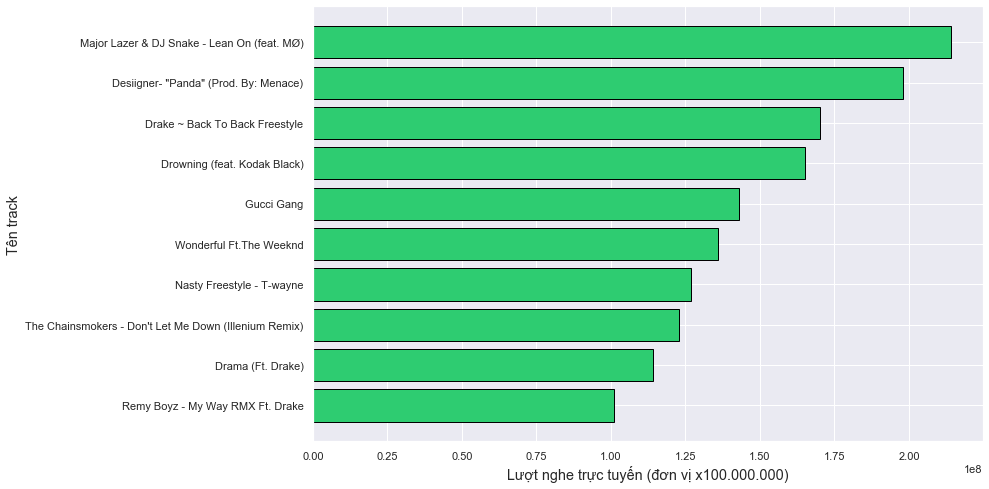

In [69]:
# question1 = df1.copy().drop_duplicates(subset=['Track_link'], keep=False)
question1_a = df1.drop_duplicates('Track_name')
question1_a = question1_a.sort_values('Play_count', ascending = True).tail(10)

sns.set(rc={'figure.figsize':(12,8)})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.barh(question1_a.Track_name, question1_a.Play_count, fill='black', color="#2ecc71", edgecolor=['black'])
ax.set_ylabel('Tên track', fontsize='large')
ax.set_xlabel('Lượt nghe trực tuyến (đơn vị x100.000.000)', fontsize='large')
# plt.xticks(rotation=90)

**Đánh giá:** Dựa vào biểu đồ trên, ta dễ thấy các track đang thịnh hành hiện nay. Đứng đầu là track "Major Lazer & DJ Snake - Lean On (feat. MØ)" với hơn 200 triệu lượt nghe, con số này chỉ nhỉnh hơn đôi chút so với các track khác trong top 4 và bỏ xa phần còn lại.

Để xét tính thịnh hành, thì cần đề cập đến tần suất xuất hiện của các track như sau:

Text(0.5, 0, 'Số lần xuất hiện trong các playlist')

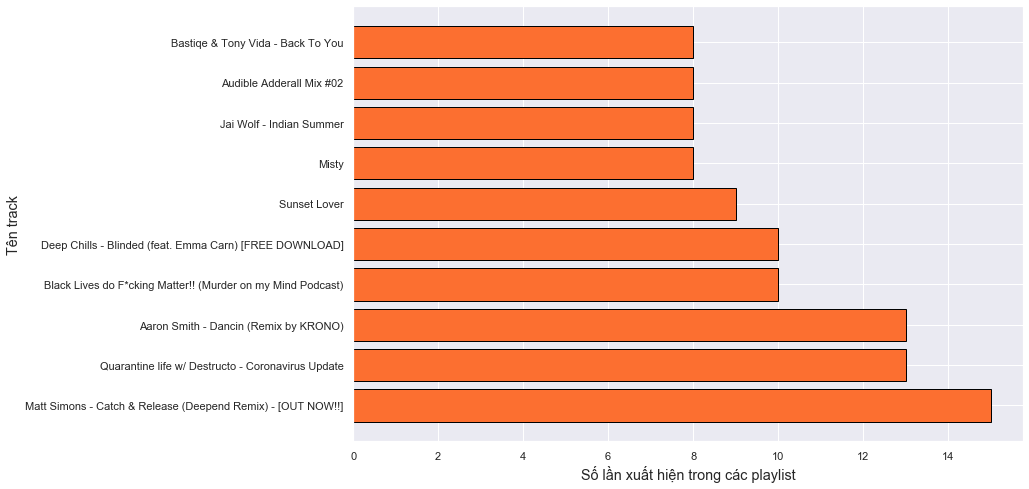

In [70]:
question1_b = df1['Track_name'].value_counts()
sns.set(rc={'figure.figsize':(12,8)})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.barh(question1_b.index[:10], question1_b.values[:10], fill='black', color="#fc6f30", edgecolor=['black'])
ax.set_ylabel('Tên track', fontsize='large')
ax.set_xlabel('Số lần xuất hiện trong các playlist', fontsize='large')

**Đánh giá:** Qua biểu đồ trên, có thể thấy các track xuất hiện ở nhiều playlist nhất như "Matt Simons - Catch & Release (Deepend Remix) - \[OUT NOW!!\]", "Quarantine life w/ Destructo - Coronavirus Update"... đều không nằm trong top có lượt nghe nhiều nhất. Do đó có thể thấy việc xuất hiện ở nhiều playlist chỉ ra xu hướng của âm nhạc thời gian gần đây nên lượt nghe có thể không cao bằng các track cũ.

**Kết luận:** Đa số các track xuất hiện ở nhiều playlist đều không nằm trong top có lượt nghe nhiều nhất. Do đó có thể thấy việc xuất hiện ở nhiều playlist chỉ ra xu hướng của âm nhạc thời gian gần đây nên lượt nghe có thể không cao bằng các track cũ.

- **<font color=red> 2. Thời lượng của các track trên Soundcloud?</font>**

- Sử dụng Boxplot biểu diễn thời gian của các track:

279.2828753928825


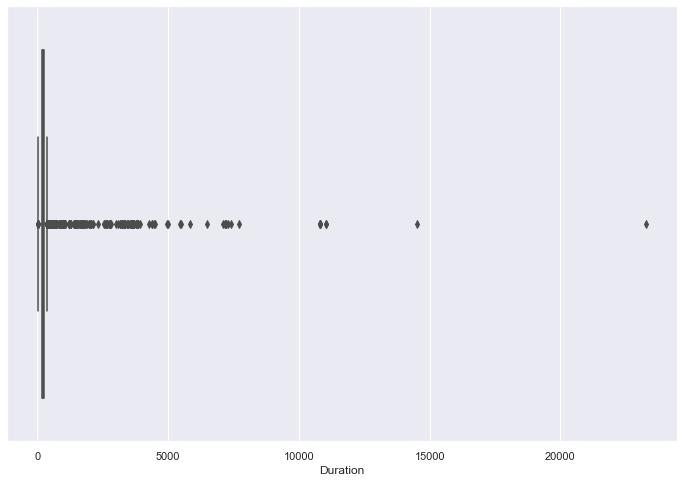

In [135]:
plt.figure(figsize=(12,8))
sns.boxplot(df1.Duration)
print(np.mean(df1.Duration))

**Đánh giá:** Ta thấy độ dài trung bình của 1 track chỉ vào khoảng gần 300s, tức 5 phút. Tuy nhiên vẫn có những track cá biệt có độ dài lớn hơn 5000s (hơn 1 tiếng rưỡi), thậm chí là hơn 20000s, con số thực sự rất lớn.

- **<font color=red> 3. Mức độ phổ biến của các loại tài khoản người dùng?</font>**

In [80]:
question2_a = df2['User_type'].value_counts()
print("Các loại tài khoản trên Soundcloud:")
for i in question2_a.index:
    print("-{}\n".format(i))

Các loại tài khoản trên Soundcloud:
-Pro Unlimited

-Basic

-Pro



Vậy có 3 loại tài khoản người dùng trên Soundcloud gồm: Basic, Pro và Pro Unlimited.

Ta bắt đầu phân tích sự khác biệt giữa 3 loại này thông qua số track đăng tải được:

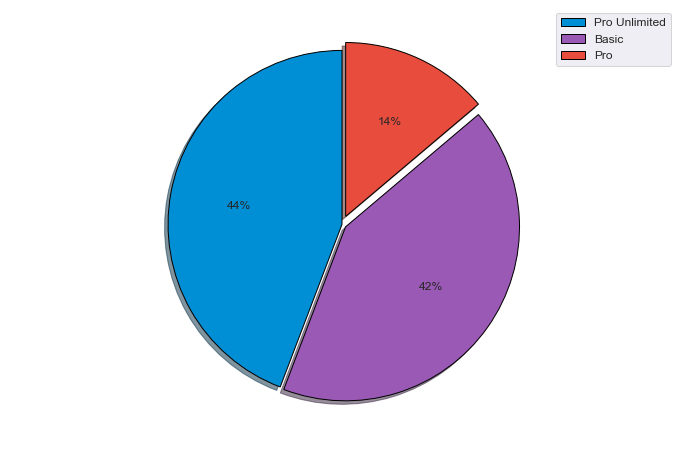

In [90]:
plt.figure(figsize=(12,8))
plt.axis('equal');
# colors = ['#008fd5', '#fc4f30']
colors = ['#008fd5', '#9b59b6', '#e74c3c']
plt.pie(question2_a, startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, 
        explode = (0, 0.025, 0.05), autopct='%1.f%%',shadow=True);
plt.legend(loc='best', labels=question2_a.index, fontsize='medium')

**Đánh giá:** Dễ thấy trên biểu đồ hình quạt, đa số các tài khoản sở hữ các track xuất hiện trên trang chủ là những tài khoản loại Basic và Pro Unlimited, với thị phần đều hơn 40%. Ở lượng người dùng còn lại (tài khoản Pro), chiểm tỉ trọng khá thấp.  

**Kết quả:** Qua kết quả, ta thấy được sự ưa chuộng của người dùng đối với gói Pro Unlimited. Họ sẵn sàng nâng thẳng lên gói Unlimited thay vì chỉ Pro, phần nào vì mức giá chênh không quá nhiều nhưng nhận lại ưu đãi lớn hơn.

Tuy nhiên, đây chỉ là một lượng NHỎ thông tin người dùng, nên kết quả trên chỉ dừng ở mức suy đoán.

- **<font color=red> 4. Có phải playlist càng lâu (tình từ thời gian đăng) thì càng nhận được nhiều lượt thích?</font>**

Trực quan hóa để thể hiện sự tương quan giữa thuộc tính playlist_posted_time và playlist_likes bằng biểu đồ scatter:

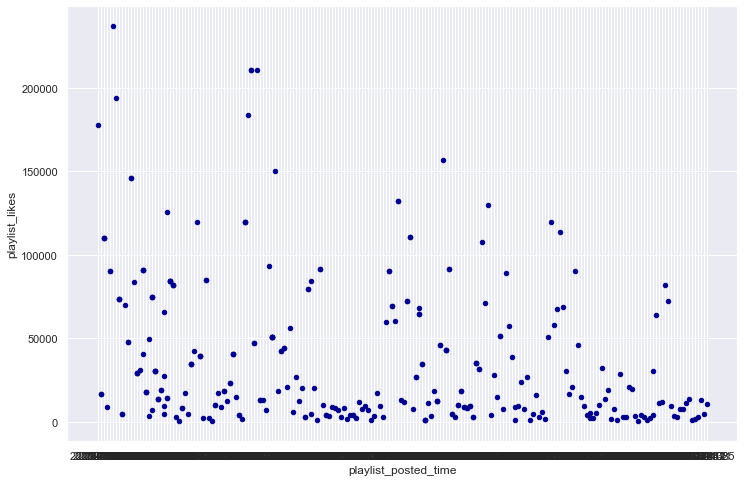

In [108]:
ax = df3.plot.scatter(x='playlist_posted_time',
                      y='playlist_likes',
                      c='DarkBlue')
plt.show()

**Đánh giá và kết luận:** Nhìn chung, câu hỏi nghi vấn trên có thể đúng. Có thể nhận ra xu hướng các điểm biểu diễn thấp dần theo đà tăng của thời gian, nhưng mức độ không đủ để đưa ra một kết luận cụ thể. Ta thấy vẫn còn những điểm dưới 50000 like hẫu như không ảnh hưởng bởi ngày đăng.   

## Lưu ý: 

Tất cả những đánh giá trên chỉ mang tính khách quan vì bộ dữ liệu chưa đủ **LỚN** đế đưa ra kết luận chung cho các thông tin trên Soundcloud.